<a href="https://colab.research.google.com/github/safreitas2000/ml-analytics-mvp/blob/main/PNL_transformer_dataset_restaurante_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# instalando dependências
! pip install transformers[torch] datasets evaluate scikit-learn matplotlib #pip install dataset instala biblioteca do hugging face

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.9 MB/s eta 0:00:00


In [2]:
# carregando dados do HF
from datasets import load_dataset
#from sklearn.model_selection import train_test_split

url_test = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/test.csv"
url_train = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/train.csv"

dataset = load_dataset('csv', data_files={'train': url_train, 'test': url_test}, column_names=['text', 'label', 'Recommends'], skiprows=[0])

dataset = dataset.class_encode_column(column="label") # precisa pro trainer saber qual a coluna precisa aprender a predizer

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-fa214d78ea79f446/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Stringifying the column:   0%|          | 0/13276 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/13276 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/3321 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/3321 [00:00<?, ? examples/s]

In [4]:
dataset["train"] = dataset["train"].remove_columns("Recommends")
dataset["test"] = dataset["test"].remove_columns("Recommends")

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 13276
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3321
    })
})

## Preparação e pre-processamento dos Dados

In [6]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Converter o dataset para um DataFrame pandas
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

# Remover as linhas com valores vazios ou None
df_train = df_train.dropna()
df_test = df_test.dropna()
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train['label'] = df_train['label'].astype('int64')
df_test['label'] = df_test['label'].astype('int64')

df_train.loc[:, "text"] = df_train["text"].str.encode("ascii", "ignore").str.decode("utf-8")
df_test.loc[:, "text"] = df_test["text"].str.encode("ascii", "ignore").str.decode("utf-8")

# Converter o DataFrame de volta para o formato de Dataset
dataset["train"] = Dataset.from_pandas(df_train)
dataset["test"] = Dataset.from_pandas(df_test)

In [10]:
# gerando datasets menores para treino, validação e teste (para poupar tempo)
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000)) # pega de 0 a 999 para o treino
small_dev_dataset = dataset["train"].shuffle(seed=42).select(range(1000,1500)) # pega os dados de 1.000 a 1.499 para validação
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(500)) #pega 500 do teste

## Visualização da Base de Treino e Teste

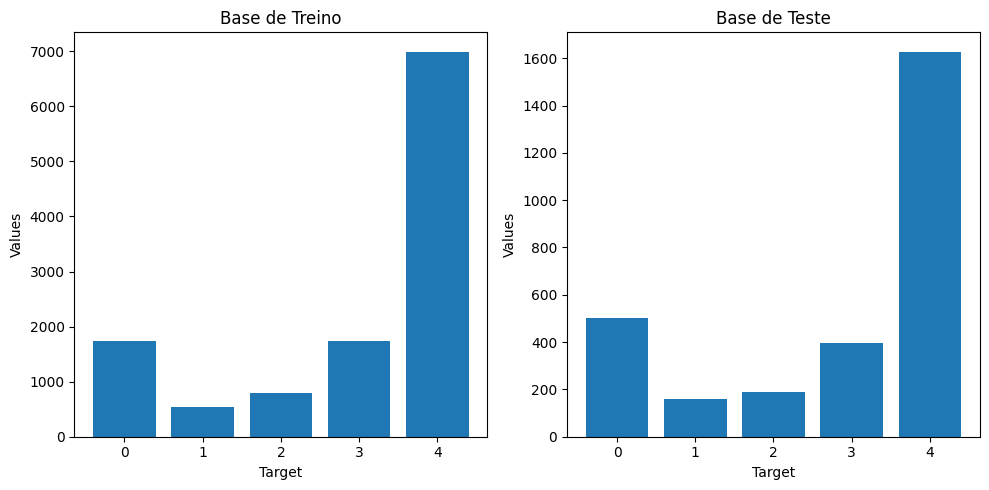

In [7]:
import matplotlib.pyplot as plt

rat_train=df_train.label.value_counts()
rat_test=df_test.label.value_counts()

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotagem do primeiro gráfico
axes[0].bar(rat_train.index, rat_train.values)
axes[0].set_xticks(rat_train.index)
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Values')
axes[0].set_title('Base de Treino')


# Plotagem do segundo gráfico
axes[1].bar(rat_test.index, rat_test.values)
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Values')
axes[1].set_title('Base de Teste')

# Ajuste de layout e exibição dos gráficos
plt.tight_layout()
plt.show()

In [17]:
#verifica quantos labels únicos temos
set(dataset["train"] ["label"])
#dataset["train"]

{0, 1, 2, 3, 4}

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11802
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2876
    })
})

In [ ]:
#dataset["train"] = dataset["train"].remove_columns("__index_level_0__")
#dataset["test"] = dataset["test"].remove_columns("__index_level_0__")

## Pre-processamento utilizando o AutoTokenizer

In [77]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# carregando modelo BERT pré-treinado e o tokenizer do modelo pré-treinado

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [12]:
#chama a função tokenized e aplica em cada linha do texto
#método map passa uma função em todo o dataset
#o toquenizador criou input_ids', 'token_type_ids', 'attention_mask'

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_small_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_small_dev_dataset = small_dev_dataset.map(tokenize_function, batched=True)
#tokenized_small_test_dataset = small_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [13]:
#visualização do dataset
import pandas as pd

small_train_df = pd.DataFrame(tokenized_small_train_dataset)
small_train_df.head(10)

,text,label,input_ids,token_type_ids,attention_mask
0,Chicken chap and luchi... Awsm taste...with an...,4,"[101, 18770, 22572, 11478, 1105, 181, 16643, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,One of my favourite..I just loved the decorati...,4,"[101, 1448, 1104, 1139, 9122, 119, 119, 146, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"Undoubtedly,one of the best place for pizza,pa...",4,"[101, 12118, 2572, 10354, 1906, 1193, 117, 114...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Taste of the foods were phenomenal the steak w...,4,"[101, 27589, 1104, 1103, 11785, 1127, 14343, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Hidden camera in girls washroom. Everyone boyc...,0,"[101, 19595, 4504, 1107, 2636, 10124, 6077, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,", , ? , , ...",1,"[101, 117, 117, 136, 117, 117, 117, 119, 119, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
6,"Average,, not good at all..quantity and qualit...",2,"[101, 18098, 117, 117, 1136, 1363, 1120, 1155,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,It's wallah and delicious... Keep up this fabu...,3,"[101, 1135, 112, 188, 2095, 3354, 1105, 13108,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,osmmmm place & also osmmm food I loved it ...,4,"[101, 184, 6602, 6262, 1306, 1282, 111, 1145, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,"Classy & delicious food menu , elegant space t...",4,"[101, 3699, 1183, 111, 13108, 2094, 13171, 117...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [14]:
#ver o dado toquenizado
#tokenized_small_train_dataset [0]


## Definição do modelo

In [15]:
from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate #biblioteca para carregar métrica

metric = evaluate.load("accuracy")

#cria uma função para computar a métrica
def compute_metrics(eval_pred): #eval_pred é o que o modelo previu
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1) #pega o id que tem maior probabilidade
    return metric.compute(predictions=predictions, references=labels) #compara o ID predito com o label esperado

#onde vai salvar o modelo treinado
MODEL_PATH = "modelo_aula_bert_2"

training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    evaluation_strategy="steps", #fazer o evaluation no step de validação a cada 10 steps
    eval_steps=10,
    per_device_train_batch_size=8,#8
    per_device_eval_batch_size=8,#8
    gradient_accumulation_steps=4, #4 gradient_accumulation_steps* per_device_eval_batch_size=batch
    max_steps=200,  # 200 por quantos steps eu quero treinar o modelo
    learning_rate=3e-5, #3e-5
    logging_strategy="steps", #a cada 10 steps vai printar
    logging_steps=10,
    save_steps=50, #salvar check point a cada 50 steps
    load_best_model_at_end=True, #pega o melhor dos que salvou
    metric_for_best_model="accuracy",
    greater_is_better=True, #se for maior é bom pq acurácia é medida de acerto
    save_total_limit=2, #quantos checkpoints vai salvar
    disable_tqdm=False #aparece a barrinha carregando
)
#entra com o modelo definido acima, os argumentos e os datasets, o trainer espera a função que computa a métrica
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_small_train_dataset,
    eval_dataset=tokenized_small_dev_dataset,
    compute_metrics=compute_metrics,
)

# Treinamento

In [18]:
#treina o modelo
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
10,1.197700,1.063974,0.576000
20,1.013600,0.923129,0.704000
30,0.895200,0.862668,0.716000
40,0.773000,0.850350,0.714000
50,0.680500,0.845326,0.724000
60,0.777200,0.842289,0.700000
70,0.670900,0.817932,0.692000
80,0.589800,0.808632,0.706000
90,0.591300,0.824079,0.688000
100,0.513600,0.838182,0.692000


TrainOutput(global_step=200, training_loss=0.5784582865238189, metrics={'train_runtime': 926.2402, 'train_samples_per_second': 6.91, 'train_steps_per_second': 0.216, 'total_flos': 1766048972218368.0, 'train_loss': 0.5784582865238189, 'epoch': 6.4})

## Plotagem

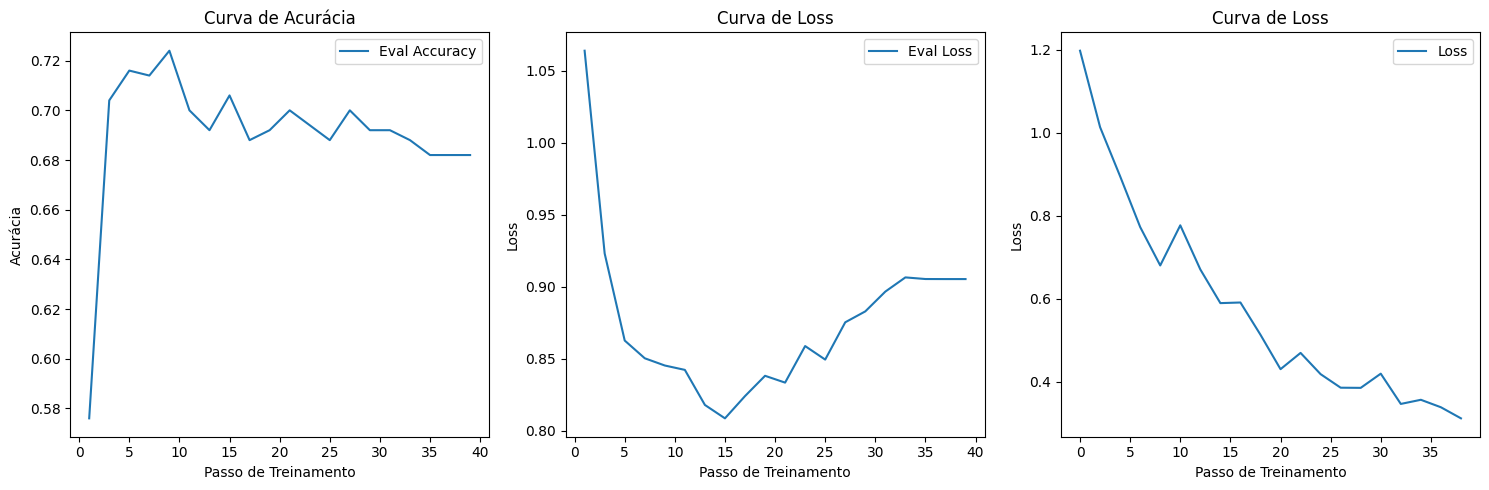

In [75]:
import pandas as pd

df_log = pd.DataFrame(trainer.state.log_history)

# Criar uma figura e eixos para os subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotar a curva de eval_accuracy
axes[0].plot(df_log["eval_accuracy"].dropna())
axes[0].set_xlabel('Passo de Treinamento')
axes[0].set_ylabel('Acurácia')
axes[0].set_title('Curva de Acurácia')

# Plotar a curva de eval_loss
axes[1].plot(df_log["eval_loss"].dropna())
axes[1].set_xlabel('Passo de Treinamento')
axes[1].set_ylabel('Loss')
axes[1].set_title('Curva de Loss')

# Plotar a curva de loss
axes[2].plot(df_log["loss"].dropna())
axes[2].set_xlabel('Passo de Treinamento')
axes[2].set_ylabel('Loss')
axes[2].set_title('Curva de Loss')

# Adicionar legendas
axes[0].legend(["Eval Accuracy"])
axes[1].legend(["Eval Loss"])
axes[2].legend(["Loss"])

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir os gráficos lado a lado
plt.show()




## Outros

In [71]:
#verifica se loss está muito ruidoso (sobe e desce) que o learning rate pode estar muito alto ou o dado estar ruim
import pandas as pd

df_log = pd.DataFrame(trainer.state.log_history)
df_log

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.1977,2.565000e-05,0.32,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.32,10,1.063974,0.576,17.0159,29.384,3.702,NaN,NaN,NaN,NaN,NaN
2,1.0136,2.415000e-05,0.64,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.64,20,0.923129,0.704,16.5018,30.300,3.818,NaN,NaN,NaN,NaN,NaN
4,0.8952,2.265000e-05,0.96,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.96,30,0.862668,0.716,16.8164,29.733,3.746,NaN,NaN,NaN,NaN,NaN
6,0.7730,2.115000e-05,1.28,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,1.28,40,0.850350,0.714,16.6858,29.966,3.776,NaN,NaN,NaN,NaN,NaN
8,0.6805,1.965000e-05,1.60,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,1.60,50,0.845326,0.724,16.7514,29.848,3.761,NaN,NaN,NaN,NaN,NaN


In [76]:
#salva o modelo e o tokenizador
trainer.save_model(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)

('/content/drive/MyDrive/modelo_aula_bert_2/tokenizer_config.json',
 '/content/drive/MyDrive/modelo_aula_bert_2/special_tokens_map.json',
 '/content/drive/MyDrive/modelo_aula_bert_2/vocab.txt',
 '/content/drive/MyDrive/modelo_aula_bert_2/added_tokens.json',
 '/content/drive/MyDrive/modelo_aula_bert_2/tokenizer.json')

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [63]:
MODEL_PATH = '/content/drive/MyDrive/modelo_aula_bert_2'

In [64]:
import torch.nn.functional as F
import torch
#carrega o nosso modelo que salvamos no ambiente de execução do colab/podemos salvar no computador para não ter que treinar novamente
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

OSError: ignored

In [ ]:
# Criar uma lista para armazenar as predições
predictions = []
real = []

# Iterar sobre as amostras do dataset
for example in small_test_dataset:
    # Tokenizar o texto
    encoded_input = tokenizer(example["text"], return_tensors="pt")

    # Passar os dados tokenizados pelo modelo
    output = model(**encoded_input)
    probs = torch.softmax(output.logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    #print(probs)
    # Armazenar a predição na lista de predições
    predictions.append(pred)
    real.append(example["label"])

# Imprimir as predições
print(predictions)
print(real)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

cm=confusion_matrix(real,predictions)
sns.heatmap(cm,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")